In [135]:
library(sits)
library(sitsdata)
library(dplyr)
library(ggplot2)
library(plotly)
library(stars)
library(leaflet)

In [113]:
read_file <- function(file, ext) {
  data.tb <- NULL
  if (ext == "csv") {
    data.tb <- read.csv(file)
  }
  if (ext == "rds") {
    data.tb <- readRDS(file)
  }
  if (ext == "rda") {
    data.tb <- get(load(file))
  }
  return(data.tb)
}

In [217]:
point_to_shape_sp <- function (data.tb, class_label) {
  group_shape <- dplyr::select(data.tb,
    longitude, latitude,
    start_date, end_date,
    label #, cube
  )
  sp_data.tb.df <- as.data.frame(group_shape)
  sp_data.tb.df <- sp_data.tb.df %>% filter(label == class_label)
  points_SF <- as.data.frame(sp_data.tb.df)
  xy <- points_SF[, c(1, 2)]
  sp_data.df <- sp::SpatialPointsDataFrame(
    coords = xy,
    data = points_SF,
    proj4string = sp::CRS("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")
  )
  return(sp_data.df)
}

In [221]:
as_sample <- function(data.tb) {
    data.tb <- as.data.frame(data.tb)
#     data.tb <- dplyr::select(data.tb, -cube)
#     data.tb <- dplyr::mutate(data.tb, cube = coverage, .after = 5)
#     data.tb <- dplyr::select(data.tb, -coverage, -time_series)
#     data.tb <- dplyr::select(data.tb, -time_series)
    return(data.tb)
}

In [211]:
save_file <- function(data.tb, name) {
    write.csv(data.tb, paste("./data/", name, ".csv"), row.names = FALSE)
    save(data.tb, file = paste("./data/", name, ".rda"))
}

In [222]:
file_name <- "sits-bundle/sitsdata/extdata/TerraClass/samples_terraclass_2017_2018.csv"
ext <- "csv"

In [223]:
input_data.tb <- read_file(file_name, ext)
input_data.tb <- as_sample(input_data.tb)
head(input_data.tb, 5)

,longitude,latitude,label,start_date,end_date
,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,-47.55016,-15.57794,Soy,2017-09-01,2018-08-31
2,-47.54388,-15.57687,Soy,2017-09-01,2018-08-31
3,-47.53704,-15.57730,Soy_Corn,2017-09-01,2018-08-31
4,-47.53081,-15.57782,Soy_Corn,2017-09-01,2018-08-31
5,-47.52714,-15.57738,Soy_Corn,2017-09-01,2018-08-31


In [224]:
group <- dplyr::group_by(input_data.tb, label)
agregation <- dplyr::summarise(group, n = n(), .groups = "drop_last")
mutation <- dplyr::mutate(agregation, percent = n/sum(n))
mutation <- data.frame(mutation)
mutation

label,n,percent
<chr>,<int>,<dbl>
Agr. Semi-Perene,1,0.0001135460
Agr. Temp. 1,17,0.0019302827
Agriculture,19,0.0021573748
Algodao,60,0.0068127626
Cafe,19,0.0021573748
Campo_Cerrado,244,0.0277052345
Cerradao,477,0.0541614625
Cerrado,2299,0.2610423527
Citrus,11,0.0012490065


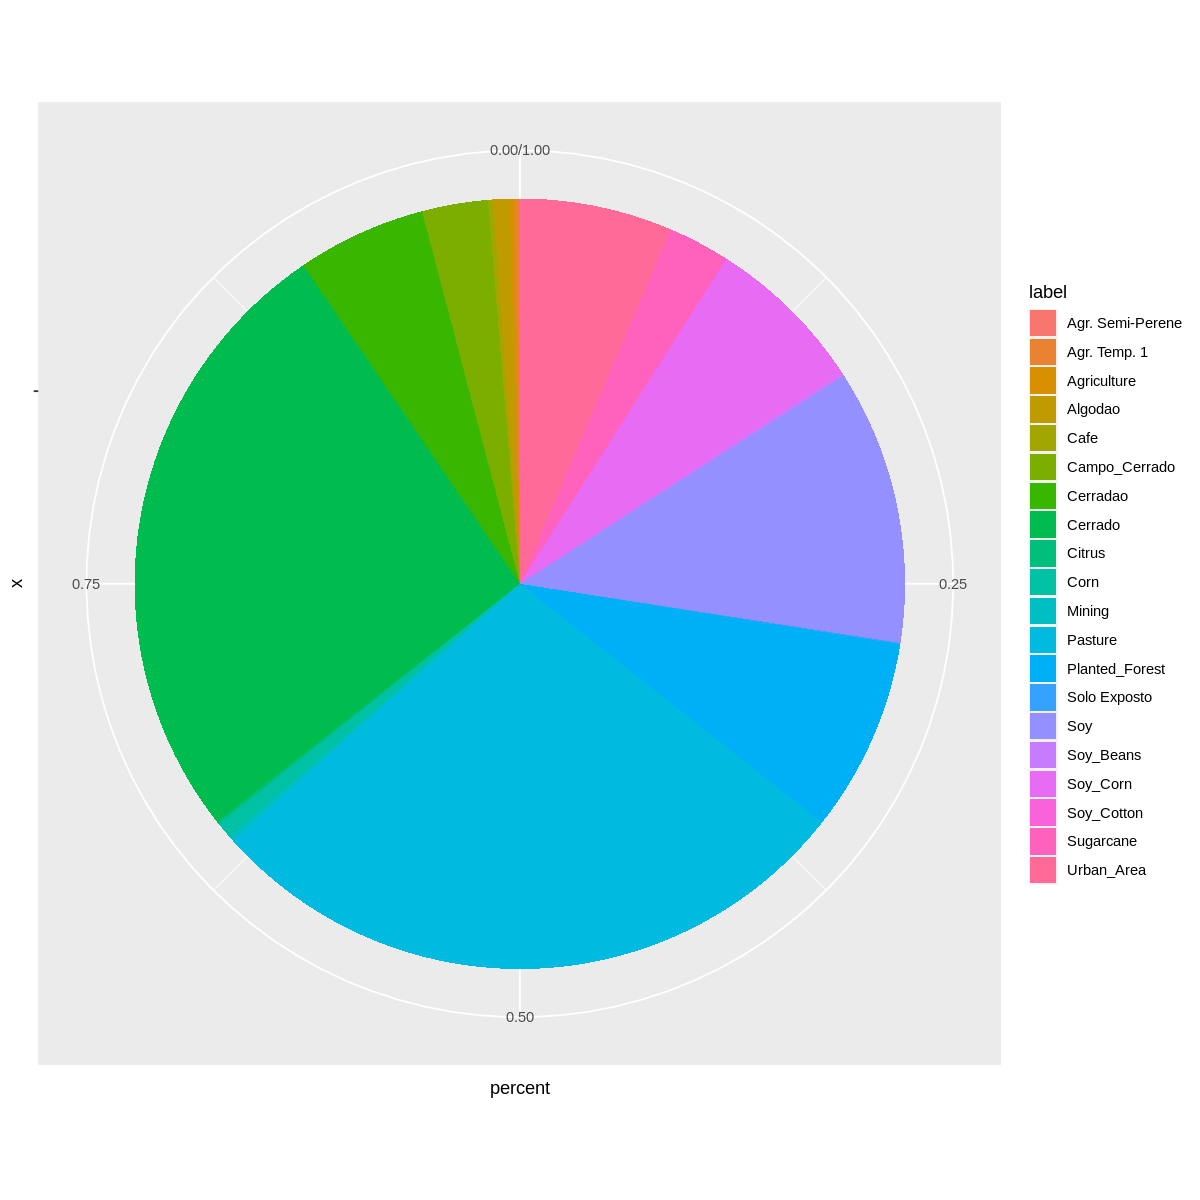

In [225]:
# Configure plot size 
options(repr.plot.width = 10, repr.plot.height = 10)
ggplot(
    mutation,
    aes(x="", y=percent, fill=label)
) + geom_bar(width = 1, stat = "identity") + coord_polar("y", start=0)

In [226]:
shape <- point_to_shape_sp(
    data.tb = input_data.tb,
    class_label = "Soy"
)
leaflet(shape, options = leafletOptions(minZoom = 0, maxZoom = 100)) %>%
        addTiles() %>%
            addMarkers(
                ~longitude, ~latitude,
                popup = ~as.character(
                    paste("Class '", label, "' |",
                        format(
                            as.Date(start_date),
                            format = "Start %Y-%m-%d"
                        ),
                        format(
                            as.Date(end_date),
                            format = "End %Y-%m-%d"
                        )
                    )))

HTML widgets cannot be represented in plain text (need html)

In [227]:
data_dir <- system.file("extdata/raster/mod13q1", package = "sits")
raster_cube <- sits_cube(
        source = "LOCAL",
        name = "sinop-2014",
        satellite = "TERRA",
        sensor = "MODIS",
        data_dir = data_dir,
        delim = "_",
        parse_info = c("X1", "X2", "tile", "band", "date")
)

In [228]:
points <- sits_get_data(raster_cube, file = file_name)
points

No points have been retrieved



<0 x 0 matrix>

In [8]:
filtered <- dplyr::filter(points, label == "Cropland")
plot(sits_select(filtered, bands = "NDVI"))

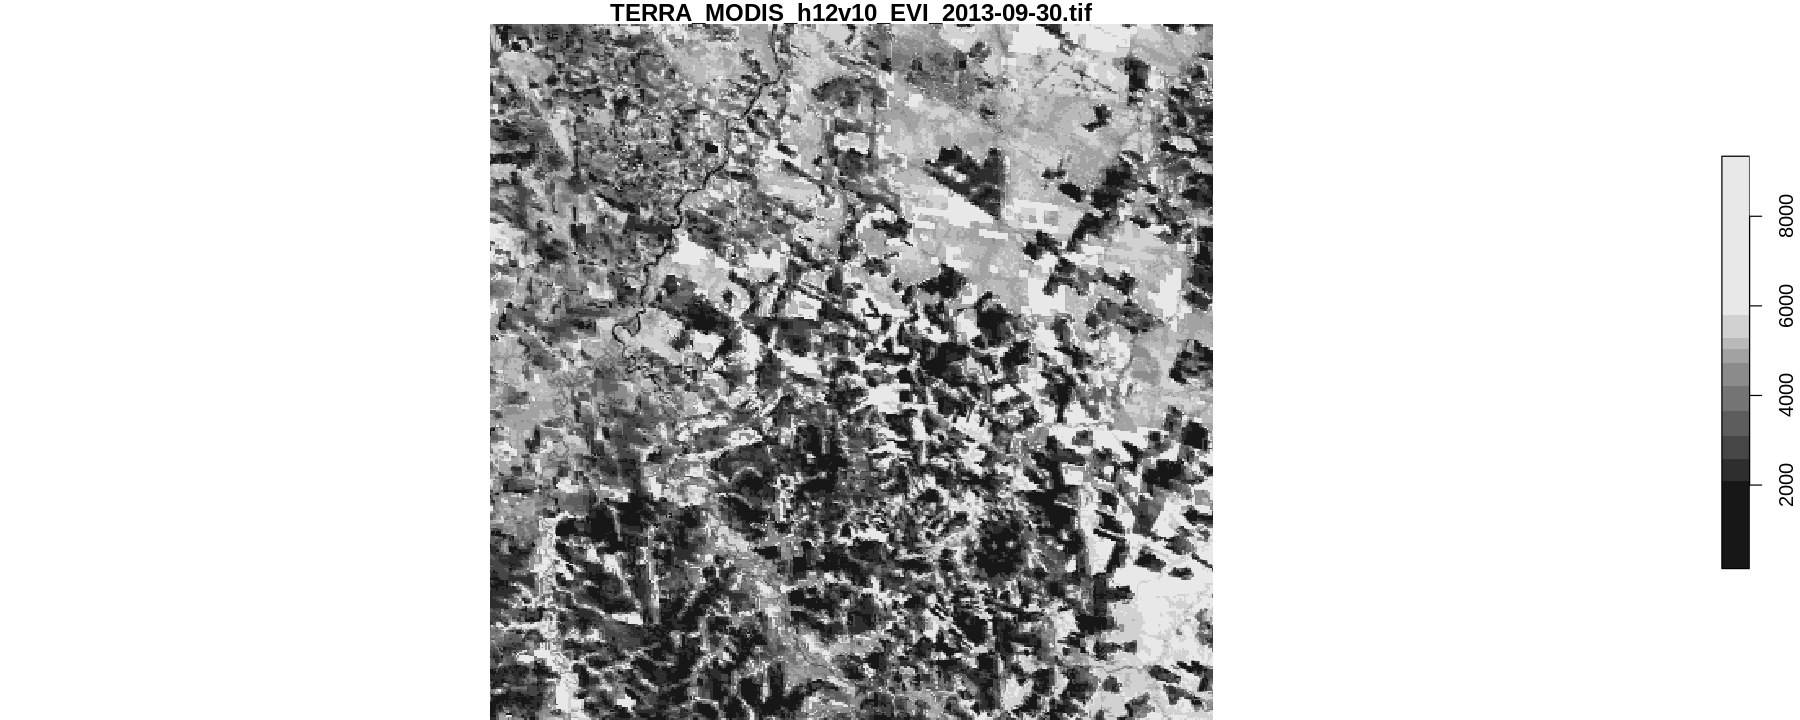

In [5]:
data_dir <- system.file("extdata/sinop", package = "sitsdata")
sinop_cube <- sits_cube(
    source = "LOCAL",
    satellite = "TERRA",
    sensor  = "MODIS",
    name = "Sinop",
    data_dir = data_dir
)
plot(sinop_cube, band = "EVI", time = 2)

In [64]:
wtss_inpe <- "https://brazildatacube.dpi.inpe.br/wtss/"
Rwtss::list_coverages(wtss_inpe)

[1] "MOD13Q1-6"               "MYD13Q1-6"              
 [3] "S2_10_16D_STK-1"         "S2-SEN2COR_10_16D_STK-1"
 [5] "S2_10-1"                 "CB4MUX_20-1"            
 [7] "CB4MUX_20_1M_STK-1"      "LC8_30-1"               
 [9] "LC8_30_16D_STK-1"        "CB4_20_1M_STK-1"        
[11] "LC8_30_6M_MEDSTK-1"      "CB4_64_16D_STK-1"       
[13] "CB4_64-1"                "LANDSAT-MOZ_30_1M_STK-1"

In [271]:
coverage <- "MOD13Q1-6"
desc <- Rwtss::describe_coverage(wtss_inpe, name = coverage)
desc$bands

---------------------------------------------------------------------
WTSS server URL = https://brazildatacube.dpi.inpe.br/wtss
Cube (coverage) = MOD13Q1-6

|satellite|sensor|bands                                                                                                                                                                                                                                                                                                                             |
|:--------|:-----|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|TERRA    |MODIS |view_zenith_angle        , sun_zenith_angle         , pixel_reliability        , relative_azimuth_angle   , blue_reflectance         , red_re

[[1]]
 [1] "view_zenith_angle"         "sun_zenith_angle"         
 [3] "pixel_reliability"         "relative_azimuth_angle"   
 [5] "blue_reflectance"          "red_reflectance"          
 [7] "NIR_reflectance"           "MIR_reflectance"          
 [9] "NDVI"                      "EVI"                      
[11] "VI_Quality"                "composite_day_of_the_year"

In [272]:
sample <- data.frame(head(input_data.tb, 1))
start <- sample$start_date
end <- sample$end_date
lat <- sample$latitude
long <- sample$longitude
bands <- c('NDVI', 'EVI', 'NIR_reflectance')

In [304]:
response = Rwtss::time_series(
    wtss_inpe, 
    name = coverage, 
    attributes = bands, 
    longitude = long,
    latitude  = lat,
    start_date = start, 
    end_date = end,
    token = "a6gB61oddyHxMAZ08y098ynEq0s1hQ3siDZao245CV"
)
cube <- response$cube
ts <- data.frame(response$time_series)
head(ts, 3)

,Index,EVI,NIR_reflectance,NDVI
,<date>,<dbl>,<dbl>,<dbl>
1,2017-09-14,0.1154,0.2533,0.1996
2,2017-09-30,0.1000,0.2562,0.1706
3,2017-10-16,0.0952,0.2384,0.1697


In [300]:
sample

,longitude,latitude,label,start_date,end_date
,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,-47.55016,-15.57794,Soy,2017-09-01,2018-08-31


In [305]:
response <- dplyr::select(response, -label)
response <- dplyr::mutate(response, label = sample$label, .after = 4)
response

longitude,latitude,start_date,end_date,label,cube,time_series
<dbl>,<dbl>,<date>,<date>,<chr>,<chr>,<list>
-47.55016,-15.57794,2017-09-01,2018-08-31,Soy,MOD13Q1-6,"17423.0000, 17439.0000, 17455.0000, 17471.0000, 17487.0000, 17503.0000, 17519.0000, 17532.0000, 17548.0000, 17564.0000, 17580.0000, 17596.0000, 17612.0000, 17628.0000, 17644.0000, 17660.0000, 17676.0000, 17692.0000, 17708.0000, 17724.0000, 17740.0000, 17756.0000, 17772.0000, 0.1154, 0.1000, 0.0952, 0.0859, 0.1322, 0.2727, 0.5446, 0.9220, 0.9241, 0.7772, 0.5063, 0.1566, 0.1769, 0.1174, 0.1472, 0.2170, 0.2881, 0.2660, 0.1727, 0.1466, 0.1337, 0.1152, 0.1231, 0.2533, 0.2562, 0.2384, 0.2436, 0.2550, 0.3707, 0.3325, 0.4492, 0.6300, 0.5313, 0.4787, 0.3173, 0.2112, 0.1570, 0.2354, 0.2263, 0.2941, 0.2652, 0.2255, 0.2242, 0.2090, 0.2011, 0.2297, 0.1996, 0.1706, 0.1697, 0.1534, 0.2330, 0.3616, 0.8105, 0.8500, 0.9148, 0.9152, 0.5975, 0.2171, 0.3249, 0.2610, 0.2700, 0.4188, 0.4690, 0.4587, 0.3284, 0.2829, 0.2594, 0.2322, 0.2211"


In [316]:
sits_select(response, "NDVI")

Warning message:
“Unknown or uninitialised column: `source`.”


ERROR: Error: .sits_config_data_meta_type: data is not valid


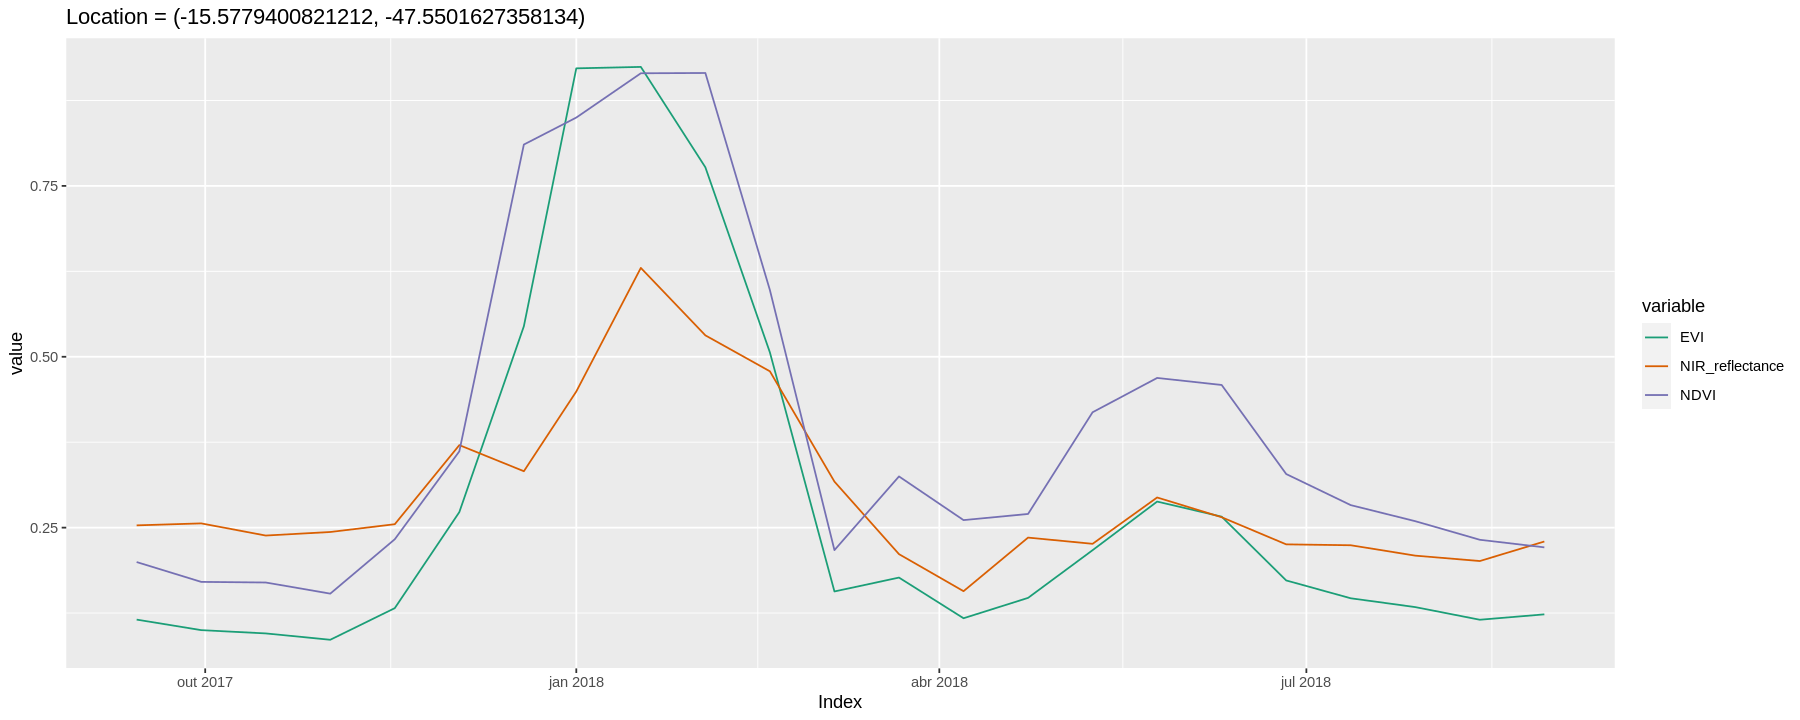

In [317]:
# Configure plot size 
options(repr.plot.width = 15, repr.plot.height = 6)
plot(response)